In [22]:
from model_utils import AudioTextCombiner

# import dataset 

import kagglehub

path = kagglehub.dataset_download("serkantysz/550k-spotify-songs-audio-lyrics-and-genres")

print("Path to dataset files:", path)

Path to dataset files: /Users/meganvaughn/.cache/kagglehub/datasets/serkantysz/550k-spotify-songs-audio-lyrics-and-genres/versions/1


In [12]:
# preprocessing

import pandas as pd

songs_path = f"{path}/songs.csv"
df = pd.read_csv(songs_path)
#df.head()

# clean data
df = df.dropna(subset=["lyrics", "genre"])
df = df[df["lyrics"].str.len() > 50]
#df.head()

# size
df = df.sample(100_000, random_state=42)
df.head()

,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,...,tempo,duration_ms,lyrics,year,genre,popularity,total_artist_followers,avg_artist_popularity,artist_ids,niche_genres
76258,0SGXz5g04bcY406eXrnHtp,Camelia,Artwork,"[""Work Of Art""]",0.565,0.885,0,-4.374,0,0.0387,...,95.030,230987,Everyone watches where ever she goes\nAnd I ge...,2008,Rock,17,19653,24.0,"[""1oBQWJ7ZDjgkJA5Z9mC2ew""]","[""aor"", ""arena rock"", ""hard rock""]"
317479,6IVRkthdux8MywUbwRO4Bx,New Age,Strange Little Girls,"[""Tori Amos""]",0.365,0.241,10,-11.568,1,0.0811,...,151.679,276960,Waiting for the phone to ring\nDiamond necklac...,2001,Folk,25,867265,56.0,"[""1KsASRNugxU85T0u6zSg32""]","[""art pop"", ""singer-songwriter""]"
196101,3IhqIhuMi40ndHFtsPvBYV,Hey Velonino,Veloninos,"[""Veloninos""]",0.618,0.905,6,-4.555,0,0.0408,...,173.031,200040,"You rumble, you tumble, you stagger, you stumb...",2016,Rock,0,138,0.0,"[""4DRVyauIjvtd5tK7vvkEdU""]","[""horror punk"", ""psychobilly"", ""rockabilly""]"
111846,0YgAwDIazcBvXVDZdZlD2D,Demons Are a Girl's Best Friend - Orchestral V...,The Symphony of Sin,"[""Powerwolf""]",0.289,0.547,1,-9.589,0,0.0333,...,143.000,219253,"Oh, oh, oh, oh-oh-oh\nDemons come at night and...",2018,Rock,17,1065320,62.0,"[""5HFkc3t0HYETL4JeEbDB1v""]","[""folk metal"", ""heavy metal"", ""medieval metal""..."
73207,1a2VusMnQOKi4FNRHAv09I,Butterfly Sign,Tripomatic Fairytales 3003,"[""Jam & Spoon"", ""PLAVKA""]",0.716,0.634,11,-5.778,1,0.0328,...,76.986,192173,"And if ever, ever I will fall in love\nMy butt...",2004,Electronic,14,48595,44.5,"[""2MIKLLJyOv1o5u49KRbfH7"", ""6ALuTGOzgoIUnuiyvq...","[""eurodance"", ""trance""]"


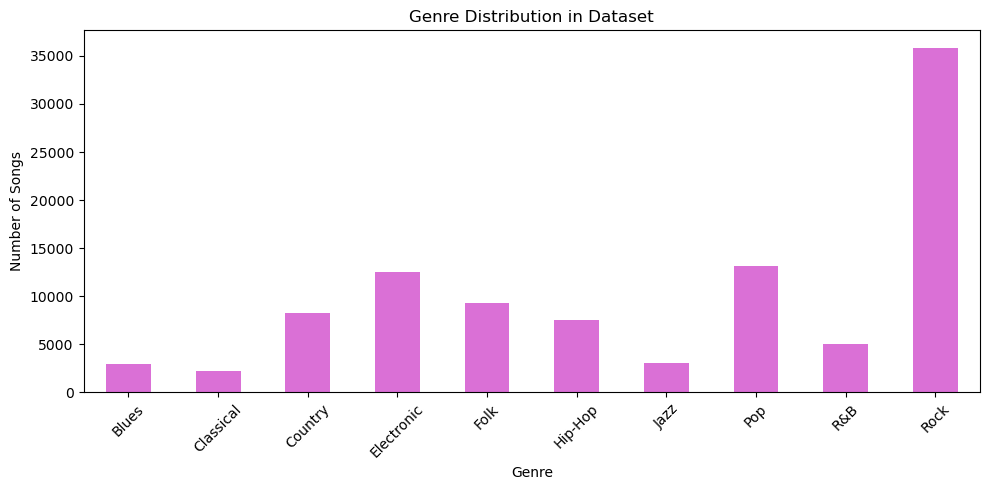

/Users/meganvaughn/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.47435

              precision    recall  f1-score   support

       Blues       0.06      0.00      0.01       582
   Classical       0.22      0.07      0.10       453
     Country       0.29      0.41      0.34      1651
  Electronic       0.48      0.41      0.44      2510
        Folk       0.20      0.10      0.13      1859
     Hip-Hop       0.54      0.61      0.58      1508
        Jazz       0.30      0.26      0.28       619
         Pop       0.17      0.08      0.11      2640
         R&B       0.27      0.06      0.10      1004
        Rock       0.58      0.86      0.69      7174

    accuracy                           0.47     20000
   macro avg       0.31      0.29      0.28     20000
weighted avg       0.40      0.47      0.42     20000



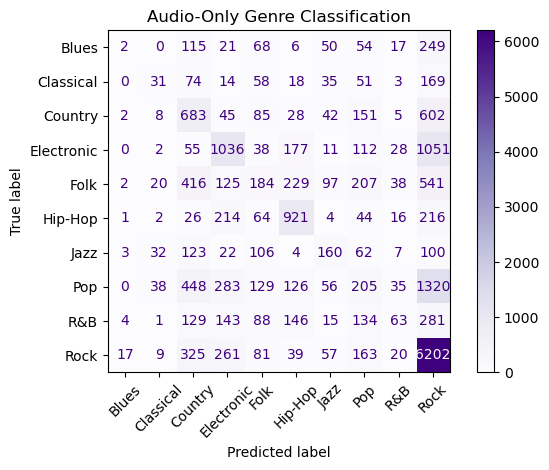

In [13]:
# audio only genre classification

# audio features
audio_features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "mode",
    "key"
]

X = df[audio_features]
y = df["genre"]

# target labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#y_encoded[:10]

# class mapping (chart)
dict(zip(le.classes_, range(len(le.classes_))))

# visualize class mapping
label_mapping = pd.DataFrame({
    "genre": le.classes_,
    "encoded_label": range(len(le.classes_))
})
label_mapping

# class mapping (bar chart)
import matplotlib.pyplot as plt
genre_counts = df["genre"].value_counts().sort_index()
plt.figure(figsize=(10, 5))
genre_counts.plot(kind="bar", color = "orchid")
plt.title("Genre Distribution in Dataset")
plt.xlabel("Genre")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

# audio only pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

audio_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=500,
        n_jobs=-1,
        multi_class="auto"
    ))
])

# train model
audio_model.fit(X_train, y_train)

# evaluate model
from sklearn.metrics import accuracy_score, classification_report

y_pred = audio_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print()
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))

# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=le.classes_,
    xticks_rotation=45,
    cmap="Purples"
)

plt.title("Audio-Only Genre Classification")
plt.tight_layout()
plt.show()


Lyrics-Only Accuracy: 0.5175

              precision    recall  f1-score   support

       Blues       0.49      0.21      0.29       582
   Classical       0.76      0.04      0.07       453
     Country       0.54      0.42      0.47      1651
  Electronic       0.43      0.32      0.37      2510
        Folk       0.51      0.23      0.32      1859
     Hip-Hop       0.79      0.70      0.74      1508
        Jazz       0.60      0.26      0.36       619
         Pop       0.34      0.29      0.31      2640
         R&B       0.44      0.29      0.35      1004
        Rock       0.54      0.84      0.65      7174

    accuracy                           0.52     20000
   macro avg       0.54      0.36      0.39     20000
weighted avg       0.51      0.52      0.49     20000



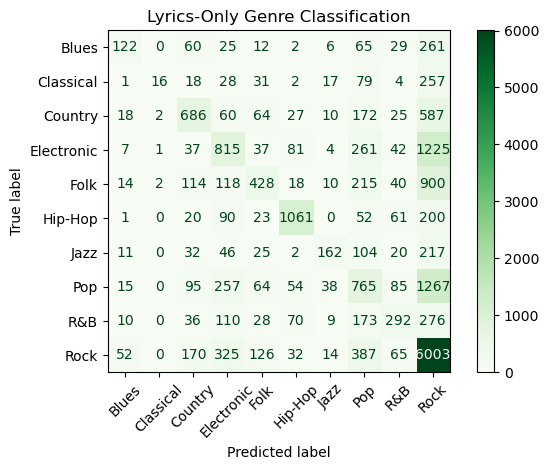


Blues:
chain chain, honey, ain, man, mama, lord, yes, woman, blues, baby

Classical:
et, thee, ll, look, isn, christine, joseph, maria, suddenly, spoken

Country:
texas, instrumental, beer, cowboy, ain, porch, lonesome, old, country, truck

Electronic:
heart heart, beat, moonlight shadow, fucking, machines, control, rave, feel, hardcore, bass

Folk:
pon, rasta, nuh, yuh, mi, reggae, inna, dem, fi, jah

Hip-Hop:
em, gon, like, yo, bitch, fuck, dey, shit, niggas, nigga

Jazz:
sleigh, love, dear, blues, stars, heart, sigh, thrill, spring, romance

Pop:
christmas, 우리, stupid, 없는, 네가, 모든, 내게, 내가, 없어, 나를

R&B:
god, love, yeah, ooh, gon, ain, tryna, girl, baby, dey

Rock:
blood, hell, suffering, void, dead, bleed, death, scream, fucking, rock roll


In [14]:
# lyrics only genre classification

# check
#df[["lyrics", "genre"]].head()

# filter to remove short lyrics
df = df[df["lyrics"].str.len() > 50]

# train test split
from sklearn.model_selection import train_test_split

X_text = df["lyrics"]

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

# vecortization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# train model
from sklearn.linear_model import LogisticRegression

lyrics_model = LogisticRegression(
    max_iter=500,
    n_jobs=-1
)

lyrics_model.fit(X_train_tfidf, y_train)

# evaluate model
from sklearn.metrics import accuracy_score, classification_report

y_pred_lyrics = lyrics_model.predict(X_test_tfidf)

print("Lyrics-Only Accuracy:", accuracy_score(y_test, y_pred_lyrics))
print()
print(classification_report(
    y_test,
    y_pred_lyrics,
    target_names=le.classes_
))

# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lyrics,
    display_labels=le.classes_,
    xticks_rotation=45,
    cmap="Greens"
)

plt.title("Lyrics-Only Genre Classification")
plt.tight_layout()
plt.show()

# top words per genre (model learning)
import numpy as np

feature_names = np.array(tfidf.get_feature_names_out())

for i, genre in enumerate(le.classes_):
    top_words = feature_names[np.argsort(lyrics_model.coef_[i])[-10:]]
    print(f"\n{genre}:")
    print(", ".join(top_words))


Multimodal Accuracy: 0.5798

              precision    recall  f1-score   support

       Blues       0.45      0.21      0.29       582
   Classical       0.47      0.17      0.25       453
     Country       0.53      0.51      0.52      1651
  Electronic       0.58      0.53      0.55      2510
        Folk       0.45      0.35      0.39      1859
     Hip-Hop       0.77      0.75      0.76      1508
        Jazz       0.59      0.44      0.50       619
         Pop       0.34      0.29      0.31      2640
         R&B       0.47      0.35      0.40      1004
        Rock       0.65      0.84      0.74      7174

    accuracy                           0.58     20000
   macro avg       0.53      0.44      0.47     20000
weighted avg       0.56      0.58      0.56     20000



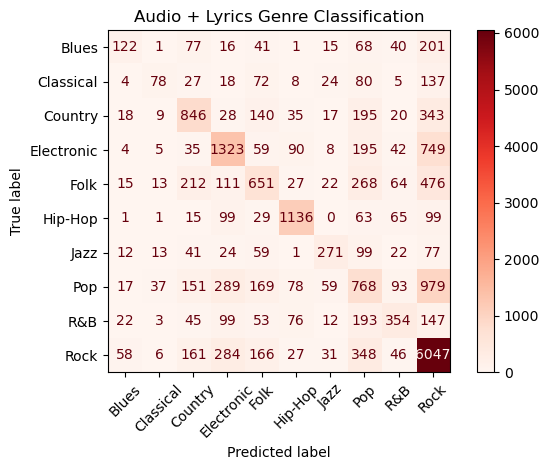

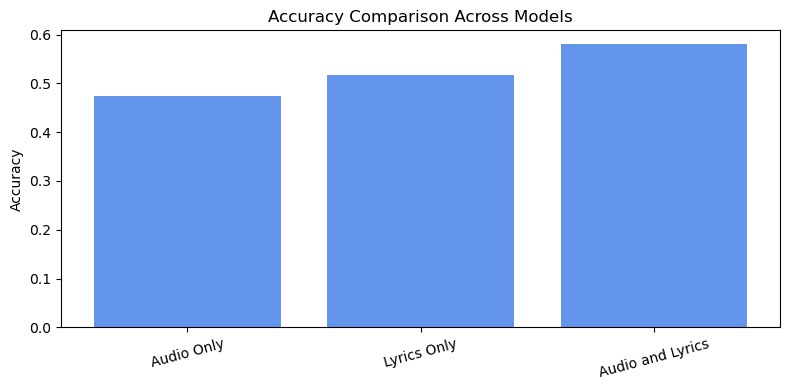

In [15]:
# audio and lyrics genre classification 

# recreate audio and text inputs
from sklearn.model_selection import train_test_split

audio_features = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo", "duration_ms", "mode", "key"
]

X_audio = df[audio_features]
X_text = df["lyrics"]
y = y_encoded  

# train test split
X_train_audio, X_test_audio, X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_audio, X_text, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# scale audio and vectorize lyrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# scale audio
scaler = StandardScaler()
X_train_audio_scaled = scaler.fit_transform(X_train_audio)
X_test_audio_scaled = scaler.transform(X_test_audio)

# TF-IDF for lyrics
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5
)

X_train_lyrics = tfidf.fit_transform(X_train_text)
X_test_lyrics = tfidf.transform(X_test_text)

# convert audio to sparse matrix
from scipy.sparse import hstack, csr_matrix

X_train_audio_sparse = csr_matrix(X_train_audio_scaled)
X_test_audio_sparse = csr_matrix(X_test_audio_scaled)

X_train_multi = hstack([X_train_audio_sparse, X_train_lyrics])
X_test_multi = hstack([X_test_audio_sparse, X_test_lyrics])

X_train_multi.shape, X_test_multi.shape

# train model
from sklearn.linear_model import LogisticRegression

multi_model = LogisticRegression(
    max_iter=500,
    n_jobs=-1
)

multi_model.fit(X_train_multi, y_train)

# evaluate model
from sklearn.metrics import accuracy_score, classification_report

y_pred_multi = multi_model.predict(X_test_multi)

print("Multimodal Accuracy:", accuracy_score(y_test, y_pred_multi))
print()
print(classification_report(
    y_test,
    y_pred_multi,
    target_names=le.classes_
))

# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_multi,
    display_labels=le.classes_,
    xticks_rotation=45,
    cmap="Reds"
)

plt.title("Audio + Lyrics Genre Classification")
plt.tight_layout()
plt.show()

# comparison of audio, lyrics, and multimodal models
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

results = pd.DataFrame({
    "Model": ["Audio Only", "Lyrics Only", "Audio and Lyrics"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_lyrics),
        accuracy_score(y_test, y_pred_multi)
    ],
    "Macro F1": [
        f1_score(y_test, y_pred, average="macro"),
        f1_score(y_test, y_pred_lyrics, average="macro"),
        f1_score(y_test, y_pred_multi, average="macro")
    ]
})

results

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(results["Model"], results["Accuracy"], color = "cornflowerblue")
plt.title("Accuracy Comparison Across Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [16]:
# hyperparameter tuning for audio model

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X_audio = df[audio_features]
y = y_encoded

X_train, X_test, y_train, y_test = train_test_split(
    X_audio, y, test_size=0.2, stratify=y, random_state=42
)

audio_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
])

audio_param_grid = {
    "clf__C": [0.1, 0.3, 1, 3, 10],
    "clf__penalty": ["l2"],  # keep simple/robust
    "clf__solver": ["lbfgs"],
}

audio_search = GridSearchCV(
    audio_pipe,
    audio_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

audio_search.fit(X_train, y_train)
print("Best audio params:", audio_search.best_params_)
print("Best audio CV macro-F1:", audio_search.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best audio params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best audio CV macro-F1: 0.277977917448471


In [17]:
# hyperparameter tuning for lyrics model

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd

# make y_encoded align to df's index
y_encoded_s = pd.Series(y_encoded, index=df.index)

df_tune = df.sample(50_000, random_state=42)

X_text = df_tune["lyrics"].astype(str)
y_tune = y_encoded_s.loc[df_tune.index].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y_tune, test_size=0.2, stratify=y_tune, random_state=42
)

lyrics_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=20000, ngram_range=(1,2), min_df=5)),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1, solver="saga"))
])

lyrics_param_grid = {
    "clf__C": [0.3, 1, 3, 10]
}

lyrics_search = GridSearchCV(
    lyrics_pipe,
    lyrics_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

lyrics_search.fit(X_train_text, y_train)

print("Best lyrics params:", lyrics_search.best_params_)
print("Best lyrics CV macro-F1:", lyrics_search.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best lyrics params: {'clf__C': 10}
Best lyrics CV macro-F1: 0.37084854293833747


In [18]:
# hyperparameter tuning for multimodal model
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

class AudioTextCombiner(BaseEstimator, TransformerMixin):
    """
    Expects X as a DataFrame containing audio_features and a 'lyrics' column.
    Returns a sparse matrix = [scaled_audio | tfidf_lyrics]
    """
    def __init__(self, audio_features, text_col="lyrics",
                 tfidf_max_features=20000, tfidf_ngram_range=(1,2), tfidf_min_df=5):
        self.audio_features = audio_features
        self.text_col = text_col
        self.tfidf_max_features = tfidf_max_features
        self.tfidf_ngram_range = tfidf_ngram_range
        self.tfidf_min_df = tfidf_min_df

        self.scaler_ = StandardScaler()
        self.tfidf_ = TfidfVectorizer(
            stop_words="english",
            max_features=self.tfidf_max_features,
            ngram_range=self.tfidf_ngram_range,
            min_df=self.tfidf_min_df
        )

    def fit(self, X, y=None):
        Xa = X[self.audio_features]
        Xt = X[self.text_col].astype(str)

        self.scaler_.fit(Xa)
        self.tfidf_.fit(Xt)
        return self

    def transform(self, X):
        Xa = X[self.audio_features]
        Xt = X[self.text_col].astype(str)

        Xa_scaled = self.scaler_.transform(Xa)
        Xa_sparse = csr_matrix(Xa_scaled)

        Xt_tfidf = self.tfidf_.transform(Xt)
        return hstack([Xa_sparse, Xt_tfidf])

# Prepare combined X
X = df[audio_features + ["lyrics"]]
y = y_encoded

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

multi_pipe = Pipeline([
    ("combine", AudioTextCombiner(audio_features=audio_features)),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
])

multi_param_grid = {
    "combine__tfidf_max_features": [20000],
    "combine__tfidf_ngram_range": [(1,2)],
    "combine__tfidf_min_df": [5],
    "clf__C": [0.3, 1, 3]
}

multi_search = GridSearchCV(
    multi_pipe,
    multi_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

multi_search.fit(X_train, y_train)
print("Best multimodal params:", multi_search.best_params_)
print("Best multimodal CV macro-F1:", multi_search.best_score_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best multimodal params: {'clf__C': 3, 'combine__tfidf_max_features': 20000, 'combine__tfidf_min_df': 5, 'combine__tfidf_ngram_range': (1, 2)}
Best multimodal CV macro-F1: 0.46390491375591586



Blues top terms:
shaggy, mississippi, arms arms, chain chain, captured, love comes, nightmare, hide hide, mistreated, lovely day, night comes, music music, baby, guitar, blues

Classical top terms:
casual, diva, underwater, gloria, mint, windy, balls, stranger stranger, kind man, joined, christine, bat, spoken, maria, ain got

Country top terms:
colorado, sinful, recall, follow home, old, tennessee, hope happy, lived, ain, hank, saw light, instrumental, truck, beer, porch

Electronic top terms:
closet, smoking, try break, let won, want right, ve ve, parallel, truth truth, end near, fans, don understand, effort, oh ah, machines, miscellaneous

Folk top terms:
strife, rasta, meh, pockets, inside let, secret life, mi, happy know, rights, wet, inna, dem, fi, reggae, jah

Hip-Hop top terms:
like, ma, oh said, motherfuckin, phone, bitch, ayy, tryna, dey, lil, hood, niggas, fuck, yo, nigga

Jazz top terms:
practice, drummers, necessarily, certain, cling, ooooo, folks, making love, ya ya, val

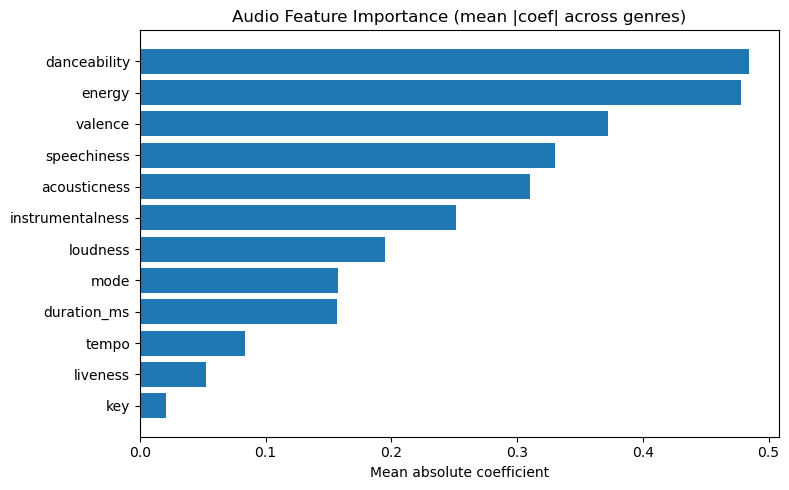

[(np.int64(883), 'Pop', 'Rock'),
 (np.int64(730), 'Electronic', 'Rock'),
 (np.int64(441), 'Folk', 'Rock'),
 (np.int64(412), 'Rock', 'Pop'),
 (np.int64(345), 'Rock', 'Electronic'),
 (np.int64(306), 'Country', 'Rock'),
 (np.int64(292), 'Folk', 'Pop'),
 (np.int64(277), 'Pop', 'Electronic'),
 (np.int64(246), 'Electronic', 'Pop'),
 (np.int64(207), 'Country', 'Pop')]

In [19]:
# interpretability 

# top words per genre (lyrics)
import numpy as np

best_lyrics_model = lyrics_search.best_estimator_  
tfidf = best_lyrics_model.named_steps["tfidf"]
clf = best_lyrics_model.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())

for i, genre in enumerate(le.classes_):
    top_idx = np.argsort(clf.coef_[i])[-15:]
    print(f"\n{genre} top terms:")
    print(", ".join(feature_names[top_idx]))

# audio feature importance, logistic regression coefficients
import pandas as pd
import numpy as np

best_audio = audio_search.best_estimator_
clf = best_audio.named_steps["clf"]

coef = clf.coef_  # shape: (n_classes, n_features)

importance = pd.DataFrame(coef, columns=audio_features, index=le.classes_)
importance.abs().mean(axis=0).sort_values(ascending=False)

# top audio features overall
import matplotlib.pyplot as plt

mean_abs = importance.abs().mean(axis=0).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(mean_abs.index, mean_abs.values)
plt.title("Audio Feature Importance (mean |coef| across genres)")
plt.xlabel("Mean absolute coefficient")
plt.tight_layout()
plt.show()

# error analysis
import numpy as np
from sklearn.metrics import confusion_matrix

# Use your best multimodal model
best_multi = multi_search.best_estimator_
y_pred = best_multi.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)

pairs = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm_off[i, j] > 0:
            pairs.append((cm_off[i, j], le.classes_[i], le.classes_[j]))

pairs_sorted = sorted(pairs, reverse=True)[:10]
pairs_sorted


In [26]:
# streamlit demo app
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

final_model = Pipeline([
    ("combine", AudioTextCombiner(audio_features=audio_features)),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1, solver="saga", C=multi_search.best_params_["clf__C"]))
])

final_model.fit(X_train, y_train)

import joblib
joblib.dump(final_model, "best_multimodal_model.joblib")
joblib.dump(le, "label_encoder.joblib")




['label_encoder.joblib']